# Method 5 - Best Ideas Low Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
best_ideas = best_ideas[best_ideas['focus_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

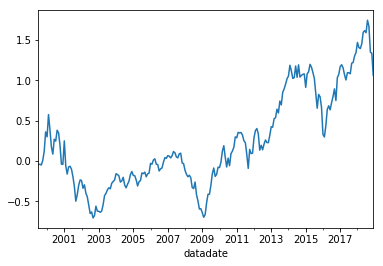

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.361846
2000-12-31   -0.294838
2001-12-31   -0.201682
2002-12-31   -0.505405
2003-12-31    1.017069
2004-12-31    0.138514
2005-12-31   -0.020985
2006-12-31    0.212824
2007-12-31   -0.062640
2008-12-31   -0.576522
2009-12-31    1.252725
2010-12-31    0.406386
2011-12-31   -0.155161
2012-12-31    0.201164
2013-12-31    0.531944
2014-12-31    0.029697
2015-12-31   -0.199633
2016-12-31    0.245830
2017-12-31    0.130039
2018-12-31   -0.120798
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     361.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.20e-97
Time:                        04:25:58   Log-Likelihood:                 437.66
No. Observations:                 234   AIC:                            -865.3
Df Residuals:                     229   BIC:                            -848.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.003      1.984      0.048    3.43e-05       0.010
mktrf          1.3522      0.070     19.239      0.000       1.214       1.491
me             0.5330      0.082      6.519      0.000       0.372       0.694
ia            -0.0523      0.124     -0.421      0.674      -0.297       0.192
roe           -1.2064      0.106    -11.342      0.000      -1.416      -0.997
==============================================================================
Omnibus:                       95.824   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              524.036
Skew:                           1.524   Prob(JB):                    1.61e-114
Kurtosis:                       9.668   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     117.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.28e-54
Time:                        04:25:58   Log-Likelihood:                 437.66
No. Observations:                 234   AIC:                            -865.3
Df Residuals:                     229   BIC:                            -848.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.003      1.911      0.056      -0.000       0.010
mktrf          1.3522      0.117     11.591      0.000       1.124       1.581
me             0.5330      0.091      5.858      0.000       0.355       0.711
ia            -0.0523      0.163     -0.321      0.748      -0.372       0.267
roe           -1.2064      0.184     -6.571      0.000      -1.566      -0.847
==============================================================================
Omnibus:                       95.824   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              524.036
Skew:                           1.524   Prob(JB):                    1.61e-114
Kurtosis:                       9.668   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     126.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.60e-57
Time:                        04:25:58   Log-Likelihood:                 437.66
No. Observations:                 234   AIC:                            -865.3
Df Residuals:                     229   BIC:                            -848.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.003      1.889      0.059      -0.000       0.010
mktrf          1.3522      0.117     11.581      0.000       1.123       1.581
me             0.5330      0.104      5.148      0.000       0.330       0.736
ia            -0.0523      0.147     -0.356      0.722      -0.340       0.236
roe           -1.2064      0.193     -6.240      0.000      -1.585      -0.827
==============================================================================
Omnibus:                       95.824   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              524.036
Skew:                           1.524   Prob(JB):                    1.61e-114
Kurtosis:                       9.668   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     225.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.84e-86
Time:                        04:25:58   Log-Likelihood:                 413.26
No. Observations:                 234   AIC:                            -814.5
Df Residuals:                     228   BIC:                            -793.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.003      1.264      0.207      -0.002       0.009
mktrf          1.4870      0.078     18.983      0.000       1.333       1.641
smb            0.6214      0.103      6.012      0.000       0.418       0.825
hml            0.2909      0.122      2.387      0.018       0.051       0.531
rmw           -0.9819      0.138     -7.126      0.000      -1.253      -0.710
cma           -0.1729      0.175     -0.987      0.325      -0.518       0.172
==============================================================================
Omnibus:                      123.986   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              748.581
Skew:                           2.051   Prob(JB):                    2.80e-163
Kurtosis:                      10.743   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     116.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.74e-61
Time:                        04:25:58   Log-Likelihood:                 413.26
No. Observations:                 234   AIC:                            -814.5
Df Residuals:                     228   BIC:                            -793.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.003      1.215      0.224      -0.002       0.010
mktrf          1.4870      0.084     17.732      0.000       1.323       1.651
smb            0.6214      0.119      5.231      0.000       0.389       0.854
hml            0.2909      0.184      1.585      0.113      -0.069       0.651
rmw           -0.9819      0.212     -4.634      0.000      -1.397      -0.567
cma           -0.1729      0.291     -0.594      0.553      -0.744       0.398
==============================================================================
Omnibus:                      123.986   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              748.581
Skew:                           2.051   Prob(JB):                    2.80e-163
Kurtosis:                      10.743   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     133.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.70e-66
Time:                        04:25:58   Log-Likelihood:                 413.26
No. Observations:                 234   AIC:                            -814.5
Df Residuals:                     228   BIC:                            -793.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.003      1.156      0.248      -0.003       0.010
mktrf          1.4870      0.075     19.945      0.000       1.341       1.633
smb            0.6214      0.117      5.305      0.000       0.392       0.851
hml            0.2909      0.148      1.965      0.049       0.001       0.581
rmw           -0.9819      0.225     -4.370      0.000      -1.422      -0.542
cma           -0.1729      0.280     -0.617      0.537      -0.723       0.377
==============================================================================
Omnibus:                      123.986   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              748.581
Skew:                           2.051   Prob(JB):                    2.80e-163
Kurtosis:                      10.743   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     316.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.44e-92
Time:                        04:25:58   Log-Likelihood:                 424.33
No. Observations:                 234   AIC:                            -838.7
Df Residuals:                     229   BIC:                            -821.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.003      0.432      0.666      -0.004       0.006
mktrf          1.5192      0.069     22.176      0.000       1.384       1.654
smb            1.0904      0.086     12.751      0.000       0.922       1.259
hml           -0.0464      0.085     -0.546      0.586      -0.214       0.121
umd           -0.4937      0.056     -8.859      0.000      -0.604      -0.384
==============================================================================
Omnibus:                       63.961   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.398
Skew:                           1.085   Prob(JB):                     9.32e-51
Kurtosis:                       7.350   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     159.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.31e-65
Time:                        04:25:58   Log-Likelihood:                 424.33
No. Observations:                 234   AIC:                            -838.7
Df Residuals:                     229   BIC:                            -821.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.477      0.633      -0.004       0.006
mktrf          1.5192      0.097     15.669      0.000       1.329       1.709
smb            1.0904      0.094     11.583      0.000       0.906       1.275
hml           -0.0464      0.107     -0.433      0.665      -0.256       0.164
umd           -0.4937      0.095     -5.218      0.000      -0.679      -0.308
==============================================================================
Omnibus:                       63.961   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.398
Skew:                           1.085   Prob(JB):                     9.32e-51
Kurtosis:                       7.350   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     154.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.58e-64
Time:                        04:25:58   Log-Likelihood:                 424.33
No. Observations:                 234   AIC:                            -838.7
Df Residuals:                     229   BIC:                            -821.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.506      0.613      -0.003       0.006
mktrf          1.5192      0.091     16.672      0.000       1.341       1.698
smb            1.0904      0.090     12.070      0.000       0.913       1.267
hml           -0.0464      0.096     -0.481      0.630      -0.235       0.142
umd           -0.4937      0.091     -5.437      0.000      -0.672      -0.316
==============================================================================
Omnibus:                       63.961   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.398
Skew:                           1.085   Prob(JB):                     9.32e-51
Kurtosis:                       7.350   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     171.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.77e-47
Time:                        04:25:58   Log-Likelihood:                 202.08
No. Observations:                 120   AIC:                            -394.2
Df Residuals:                     115   BIC:                            -380.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.004      2.009      0.047       0.000       0.018
mktrf          1.2754      0.118     10.784      0.000       1.041       1.510
me             0.4388      0.117      3.757      0.000       0.207       0.670
ia            -0.1112      0.183     -0.608      0.544      -0.474       0.251
roe           -1.2856      0.162     -7.941      0.000      -1.606      -0.965
==============================================================================
Omnibus:                       35.869   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.436
Skew:                           1.133   Prob(JB):                     2.30e-20
Kurtosis:                       6.599   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     100.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.52e-36
Time:                        04:25:58   Log-Likelihood:                 202.08
No. Observations:                 120   AIC:                            -394.2
Df Residuals:                     115   BIC:                            -380.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.004      2.208      0.027       0.001       0.017
mktrf          1.2754      0.163      7.828      0.000       0.956       1.595
me             0.4388      0.111      3.960      0.000       0.222       0.656
ia            -0.1112      0.215     -0.516      0.606      -0.534       0.311
roe           -1.2856      0.229     -5.608      0.000      -1.735      -0.836
==============================================================================
Omnibus:                       35.869   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.436
Skew:                           1.133   Prob(JB):                     2.30e-20
Kurtosis:                       6.599   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     108.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.28e-38
Time:                        04:25:58   Log-Likelihood:                 202.08
No. Observations:                 120   AIC:                            -394.2
Df Residuals:                     115   BIC:                            -380.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.004      2.352      0.019       0.001       0.016
mktrf          1.2754      0.163      7.814      0.000       0.955       1.595
me             0.4388      0.128      3.439      0.001       0.189       0.689
ia            -0.1112      0.188     -0.591      0.555      -0.480       0.258
roe           -1.2856      0.246     -5.235      0.000      -1.767      -0.804
==============================================================================
Omnibus:                       35.869   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.436
Skew:                           1.133   Prob(JB):                     2.30e-20
Kurtosis:                       6.599   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     102.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.94e-40
Time:                        04:25:58   Log-Likelihood:                 187.72
No. Observations:                 120   AIC:                            -363.4
Df Residuals:                     114   BIC:                            -346.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0081      0.005      1.583      0.116      -0.002       0.018
mktrf          1.5800      0.141     11.192      0.000       1.300       1.860
smb            0.5981      0.160      3.741      0.000       0.281       0.915
hml            0.1165      0.196      0.595      0.553      -0.272       0.505
rmw           -0.8348      0.231     -3.613      0.000      -1.293      -0.377
cma           -0.0952      0.253     -0.376      0.708      -0.597       0.406
==============================================================================
Omnibus:                       63.724   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              222.924
Skew:                           1.964   Prob(JB):                     3.91e-49
Kurtosis:                       8.400   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     49.10
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.10e-27
Time:                        04:25:58   Log-Likelihood:                 187.72
No. Observations:                 120   AIC:                            -363.4
Df Residuals:                     114   BIC:                            -346.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0081      0.004      1.849      0.064      -0.000       0.017
mktrf          1.5800      0.152     10.364      0.000       1.281       1.879
smb            0.5981      0.170      3.518      0.000       0.265       0.931
hml            0.1165      0.193      0.603      0.546      -0.262       0.495
rmw           -0.8348      0.290     -2.883      0.004      -1.402      -0.267
cma           -0.0952      0.344     -0.277      0.782      -0.768       0.578
==============================================================================
Omnibus:                       63.724   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              222.924
Skew:                           1.964   Prob(JB):                     3.91e-49
Kurtosis:                       8.400   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     58.30
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.98e-30
Time:                        04:25:58   Log-Likelihood:                 187.72
No. Observations:                 120   AIC:                            -363.4
Df Residuals:                     114   BIC:                            -346.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0081      0.004      1.868      0.062      -0.000       0.017
mktrf          1.5800      0.128     12.380      0.000       1.330       1.830
smb            0.5981      0.166      3.601      0.000       0.273       0.924
hml            0.1165      0.180      0.646      0.518      -0.237       0.470
rmw           -0.8348      0.313     -2.670      0.008      -1.448      -0.222
cma           -0.0952      0.328     -0.291      0.771      -0.737       0.547
==============================================================================
Omnibus:                       63.724   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              222.924
Skew:                           1.964   Prob(JB):                     3.91e-49
Kurtosis:                       8.400   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     160.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.09e-46
Time:                        04:25:58   Log-Likelihood:                 198.79
No. Observations:                 120   AIC:                            -387.6
Df Residuals:                     115   BIC:                            -373.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.004      1.058      0.292      -0.004       0.013
mktrf          1.5589      0.107     14.558      0.000       1.347       1.771
smb            1.0718      0.122      8.791      0.000       0.830       1.313
hml           -0.1637      0.122     -1.341      0.183      -0.406       0.078
umd           -0.4820      0.075     -6.402      0.000      -0.631      -0.333
==============================================================================
Omnibus:                       32.018   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.954
Skew:                           1.016   Prob(JB):                     1.18e-17
Kurtosis:                       6.385   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     130.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.46e-42
Time:                        04:25:58   Log-Likelihood:                 198.79
No. Observations:                 120   AIC:                            -387.6
Df Residuals:                     115   BIC:                            -373.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.003      1.378      0.168      -0.002       0.011
mktrf          1.5589      0.150     10.423      0.000       1.266       1.852
smb            1.0718      0.118      9.122      0.000       0.841       1.302
hml           -0.1637      0.140     -1.173      0.241      -0.437       0.110
umd           -0.4820      0.097     -4.980      0.000      -0.672      -0.292
==============================================================================
Omnibus:                       32.018   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.954
Skew:                           1.016   Prob(JB):                     1.18e-17
Kurtosis:                       6.385   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     137.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.61e-43
Time:                        04:25:58   Log-Likelihood:                 198.79
No. Observations:                 120   AIC:                            -387.6
Df Residuals:                     115   BIC:                            -373.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.003      1.571      0.116      -0.001       0.011
mktrf          1.5589      0.145     10.717      0.000       1.274       1.844
smb            1.0718      0.107      9.989      0.000       0.861       1.282
hml           -0.1637      0.134     -1.224      0.221      -0.426       0.099
umd           -0.4820      0.092     -5.239      0.000      -0.662      -0.302
==============================================================================
Omnibus:                       32.018   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.954
Skew:                           1.016   Prob(JB):                     1.18e-17
Kurtosis:                       6.385   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     217.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.00e-51
Time:                        04:25:58   Log-Likelihood:                 255.03
No. Observations:                 114   AIC:                            -500.1
Df Residuals:                     109   BIC:                            -486.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.003      0.556      0.579      -0.004       0.007
mktrf          1.4128      0.078     18.189      0.000       1.259       1.567
me             0.7065      0.120      5.892      0.000       0.469       0.944
ia             0.0053      0.166      0.032      0.974      -0.324       0.335
roe           -1.1331      0.146     -7.752      0.000      -1.423      -0.843
==============================================================================
Omnibus:                       41.316   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.940
Skew:                           1.262   Prob(JB):                     3.69e-29
Kurtosis:                       7.604   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     156.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.07e-44
Time:                        04:25:58   Log-Likelihood:                 255.03
No. Observations:                 114   AIC:                            -500.1
Df Residuals:                     109   BIC:                            -486.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.606      0.545      -0.003       0.006
mktrf          1.4128      0.110     12.814      0.000       1.197       1.629
me             0.7065      0.135      5.231      0.000       0.442       0.971
ia             0.0053      0.199      0.027      0.979      -0.385       0.396
roe           -1.1331      0.184     -6.152      0.000      -1.494      -0.772
==============================================================================
Omnibus:                       41.316   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.940
Skew:                           1.262   Prob(JB):                     3.69e-29
Kurtosis:                       7.604   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     171.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.28e-46
Time:                        04:25:58   Log-Likelihood:                 255.03
No. Observations:                 114   AIC:                            -500.1
Df Residuals:                     109   BIC:                            -486.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.635      0.526      -0.003       0.006
mktrf          1.4128      0.108     13.026      0.000       1.200       1.625
me             0.7065      0.156      4.515      0.000       0.400       1.013
ia             0.0053      0.221      0.024      0.981      -0.427       0.438
roe           -1.1331      0.189     -5.986      0.000      -1.504      -0.762
==============================================================================
Omnibus:                       41.316   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.940
Skew:                           1.262   Prob(JB):                     3.69e-29
Kurtosis:                       7.604   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     158.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.24e-48
Time:                        04:25:58   Log-Likelihood:                 250.59
No. Observations:                 114   AIC:                            -489.2
Df Residuals:                     108   BIC:                            -472.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.003     -0.120      0.904      -0.006       0.005
mktrf          1.4419      0.077     18.634      0.000       1.288       1.595
smb            0.6517      0.126      5.188      0.000       0.403       0.901
hml            0.5079      0.160      3.170      0.002       0.190       0.826
rmw           -1.0879      0.196     -5.546      0.000      -1.477      -0.699
cma           -0.3015      0.249     -1.211      0.229      -0.795       0.192
==============================================================================
Omnibus:                       11.616   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.707
Skew:                           0.530   Prob(JB):                     0.000388
Kurtosis:                       4.477   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     102.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.50e-39
Time:                        04:25:59   Log-Likelihood:                 250.59
No. Observations:                 114   AIC:                            -489.2
Df Residuals:                     108   BIC:                            -472.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.003     -0.097      0.923      -0.007       0.006
mktrf          1.4419      0.085     17.024      0.000       1.276       1.608
smb            0.6517      0.116      5.623      0.000       0.425       0.879
hml            0.5079      0.180      2.818      0.005       0.155       0.861
rmw           -1.0879      0.231     -4.708      0.000      -1.541      -0.635
cma           -0.3015      0.247     -1.220      0.222      -0.786       0.183
==============================================================================
Omnibus:                       11.616   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.707
Skew:                           0.530   Prob(JB):                     0.000388
Kurtosis:                       4.477   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     97.94
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.73e-38
Time:                        04:25:59   Log-Likelihood:                 250.59
No. Observations:                 114   AIC:                            -489.2
Df Residuals:                     108   BIC:                            -472.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.003     -0.096      0.924      -0.007       0.006
mktrf          1.4419      0.085     17.017      0.000       1.276       1.608
smb            0.6517      0.126      5.159      0.000       0.404       0.899
hml            0.5079      0.167      3.041      0.002       0.181       0.835
rmw           -1.0879      0.200     -5.447      0.000      -1.479      -0.696
cma           -0.3015      0.280     -1.076      0.282      -0.851       0.248
==============================================================================
Omnibus:                       11.616   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.707
Skew:                           0.530   Prob(JB):                     0.000388
Kurtosis:                       4.477   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     171.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.43e-46
Time:                        04:25:59   Log-Likelihood:                 243.09
No. Observations:                 114   AIC:                            -476.2
Df Residuals:                     109   BIC:                            -462.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.003     -0.454      0.651      -0.007       0.004
mktrf          1.4755      0.082     18.052      0.000       1.314       1.638
smb            0.9147      0.127      7.177      0.000       0.662       1.167
hml            0.3551      0.131      2.705      0.008       0.095       0.615
umd           -0.4256      0.099     -4.298      0.000      -0.622      -0.229
==============================================================================
Omnibus:                       13.647   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.707
Skew:                           0.568   Prob(JB):                     3.19e-05
Kurtosis:                       4.752   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     154.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.22e-44
Time:                        04:25:59   Log-Likelihood:                 243.09
No. Observations:                 114   AIC:                            -476.2
Df Residuals:                     109   BIC:                            -462.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.003     -0.455      0.649      -0.007       0.004
mktrf          1.4755      0.091     16.254      0.000       1.298       1.653
smb            0.9147      0.124      7.365      0.000       0.671       1.158
hml            0.3551      0.187      1.897      0.058      -0.012       0.722
umd           -0.4256      0.123     -3.455      0.001      -0.667      -0.184
==============================================================================
Omnibus:                       13.647   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.707
Skew:                           0.568   Prob(JB):                     3.19e-05
Kurtosis:                       4.752   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     203.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.48e-49
Time:                        04:25:59   Log-Likelihood:                 243.09
No. Observations:                 114   AIC:                            -476.2
Df Residuals:                     109   BIC:                            -462.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.003     -0.450      0.652      -0.007       0.004
mktrf          1.4755      0.087     16.967      0.000       1.305       1.646
smb            0.9147      0.114      8.043      0.000       0.692       1.138
hml            0.3551      0.194      1.832      0.067      -0.025       0.735
umd           -0.4256      0.128     -3.324      0.001      -0.676      -0.175
==============================================================================
Omnibus:                       13.647   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.707
Skew:                           0.568   Prob(JB):                     3.19e-05
Kurtosis:                       4.752   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""